# Train MLP on the FFOOM dataset

In [1]:
%load_ext lab_black
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from typing import List, Tuple
import seaborn as sns
import sys
import wandb

import brunoflow as bf
from brunoflow.ad import Node
from brunoflow.net import MLP
from brunoflow.opt import Adam, cross_entropy_loss, regularize
from preprocessing.datasets import MNIST, FFOOM
from utils import catchtime, gpu_memory_usage

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
try:
    import jax
    from jax import numpy as jnp

    jax_device_kind = jax.devices()[0].device_kind
    print(f"Running JAX on {jax_device_kind}")
    # if "NVIDIA" not in jax_device_kind:
    #     raise ValueError("Imported JAX, but not running on a GPU, terminating.")
except ImportError:
    print("No JAX available to import!")

Running JAX on NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), "train_ffoom_mlp.ipynb")
excluded_all_caps_params = {k for k in locals().keys() if k.isupper()}

In [4]:
# Parameters
# Data parameters
DATASET_NAME = "FFOOM"
DATASET_KWARGS_IDENTIFIABLE = {"num_points": 10000}
DATASET_KWARGS = {}
SEED = 2221
BATCH_SIZE = 32
TEST_BATCH_SIZE = 100
SAMPLING_FRACTION = 1.0

# Model parameters
INPUT_SIZE = 4  # 28x28
HIDDEN_SIZE = 8
NUM_CLASSES = 2
NUM_EPOCHS = 1
LEARNING_RATE = 0.001
L1_WEIGHT = 0.0
L2_WEIGHT = 0.0
DROPOUT_PROB = 0.0
OVERWRITE_MODEL = True

# Analysis parameters
NUM_ELEMENTS_PER_STRATA = 32

# Run parameters
PM_RUN_ID = "run_id"
PROJECT_NAME = "bauer-ffoom"
# GROUP_NAME = "regularized-loss"
# GROUP_NAME = "scratch"
# GROUP_NAME = "visualization"
GROUP_NAME = "dropout"
TAGS = ["jax", "dropout"]

In [5]:
# Construct dataset and data ids
dataset = getattr(sys.modules[__name__], DATASET_NAME)(
    **{**DATASET_KWARGS_IDENTIFIABLE, **DATASET_KWARGS}
)
data_id = f"{dataset.get_name()}"
data_dir = os.path.join("data", DATASET_NAME, data_id, f"{SAMPLING_FRACTION}-{SEED}")
input_dir = os.path.join(data_dir, "inputs")
train_data_path = os.path.join(input_dir, "train.pt")
val_data_path = os.path.join(input_dir, "val.pt")
test_data_path = os.path.join(input_dir, "test.pt")

# Construct model id
model_id = f"MLP-hidden_sz{HIDDEN_SIZE}-bs{BATCH_SIZE}-lr{LEARNING_RATE}-n{NUM_EPOCHS}"
model_id += f"-l1_weight{L1_WEIGHT}" if L1_WEIGHT != 0 else ""
model_id += f"-l2_weight{L2_WEIGHT}" if L2_WEIGHT != 0 else ""
model_id += f"-dropoutprob{DROPOUT_PROB}" if DROPOUT_PROB != 0 else ""

model_dir = os.path.join(data_dir, "models", model_id)

# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

In [6]:
params_to_log = {
    k: v
    for k, v in locals().items()
    if k.isupper() and k not in excluded_all_caps_params
}

In [7]:
run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu. Use `wandb login --relogin` to force relogin
wandb: ERROR Failed to sample metric: Not Supported


{'DATASET_NAME': 'FFOOM', 'DATASET_KWARGS_IDENTIFIABLE': {'num_points': 10000}, 'DATASET_KWARGS': {}, 'SEED': 2221, 'BATCH_SIZE': 32, 'TEST_BATCH_SIZE': 100, 'SAMPLING_FRACTION': 1.0, 'INPUT_SIZE': 4, 'HIDDEN_SIZE': 8, 'NUM_CLASSES': 2, 'NUM_EPOCHS': 1, 'LEARNING_RATE': 0.001, 'L1_WEIGHT': 0.0, 'L2_WEIGHT': 0.0, 'DROPOUT_PROB': 0.0, 'OVERWRITE_MODEL': True, 'NUM_ELEMENTS_PER_STRATA': 32, 'PM_RUN_ID': 'run_id', 'PROJECT_NAME': 'bauer-ffoom', 'GROUP_NAME': 'dropout', 'TAGS': ['jax', 'dropout']}


### Data Retrieval and Preprocessing

In [8]:
if (
    os.path.isfile(train_data_path)
    and os.path.isfile(val_data_path)
    and os.path.isfile(test_data_path)
):
    print(
        f"Loading cached train and test sets from {train_data_path} and {test_data_path}."
    )
    train_data = torch.load(train_data_path)
    val_data = torch.load(val_data_path)
    test_data = torch.load(test_data_path)
else:
    train_data = dataset.get_train_data()
    val_data = dataset.get_val_data()
    test_data = dataset.get_test_data()

    # Save the dataset
    os.makedirs(input_dir, exist_ok=True)
    torch.save(train_data, train_data_path)
    torch.save(val_data, val_data_path)
    torch.save(test_data, test_data_path)

train_kwargs = {"batch_size": BATCH_SIZE}
val_kwargs = {"batch_size": len(val_data)}
test_kwargs = {"batch_size": TEST_BATCH_SIZE}

train_loader = torch.utils.data.DataLoader(train_data, **train_kwargs)
val_loader = torch.utils.data.DataLoader(val_data, **val_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **test_kwargs)

Loading cached train and test sets from data/FFOOM/FFOOM-num_points10000/1.0-2221/inputs/train.pt and data/FFOOM/FFOOM-num_points10000/1.0-2221/inputs/test.pt.


In [9]:
# After loading/preprocessing your dataset, log it as an artifact to W&B
print(f"Logging datasets to w&b run {wandb.run}.")
artifact = wandb.Artifact(name=data_id, type="dataset")
artifact.add_dir(local_path=input_dir)
run.log_artifact(artifact)

wandb: Adding directory to artifact (./data/FFOOM/FFOOM-num_points10000/1.0-2221/inputs)... Done. 0.0s


Logging datasets to w&b run <wandb.sdk.wandb_run.Run object at 0x7fa4132f5c70>.


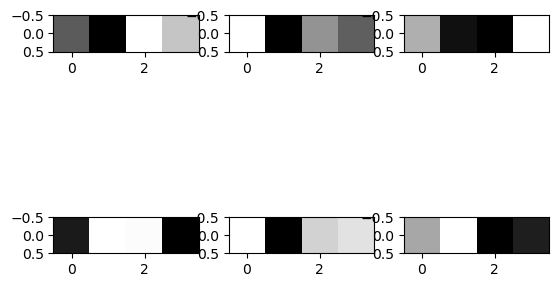

In [10]:
examples = iter(test_loader)
example_data, example_targets = examples.next()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    if DATASET_NAME == "MNIST":
        plt.imshow(example_data[i][0], cmap="gray")
    elif DATASET_NAME == "FFOOM":
        plt.imshow(example_data[i].unsqueeze(dim=0), cmap="gray")

### Define training loop

In [11]:
def validation(
    model,
    optimizer,
    val_loader,
    l1_weight,
    l2_weight,
    epoch,
    batch,
    num_strata=10,
    num_elements_per_strata=100,
    visualize=False,
):
    model.eval()
    # Construct stratified validation set based on the 0th feature value
    val_inputs, val_labels = next(iter(val_loader))

    sorted_row_indices = val_inputs[:, 0].argsort()
    val_inputs_sorted = val_inputs[sorted_row_indices].numpy()
    val_labels_sorted = val_labels[sorted_row_indices].numpy()

    val_inputs_stratified = np.split(val_inputs_sorted, num_strata, axis=0)
    val_labels_stratified = np.split(val_labels_sorted, num_strata, axis=0)

    if num_elements_per_strata < len(val_inputs_stratified[0]):
        sample_inds = np.random.choice(
            len(val_inputs_stratified[0]), num_elements_per_strata, replace=False
        )
        print(sample_inds)
        wandb.log({"sample_inds_for_validation": sample_inds})
        val_inputs_stratified = [inp[sample_inds] for inp in val_inputs_stratified]
        val_labels_stratified = [label[sample_inds] for label in val_labels_stratified]

    total_correct, total_entropy, total_val_points = 0, 0, 0
    total_entropy_per_feature = np.zeros(shape=(4,))

    val_metrics_list = []
    val_metrics = dict()

    import tempfile

    temp_dir = (
        tempfile.TemporaryDirectory()
    )  # for saving and logging graph visualizations

    for i in range(num_strata):
        inputs = Node(val_inputs_stratified[i], name="val_inputs")
        labels = val_labels_stratified[i]

        # Apply model and compute entropy
        outputs = model(inputs)
        unregularized_loss = cross_entropy_loss(outputs, labels)
        loss = unregularized_loss + regularize(
            model=model, l1_weight=l1_weight, l2_weight=l2_weight
        )

        # Zero out all semiring values (e.g. gradients, entropy, etc) from the previous minibatch to compute the gradients and entropy correctly.
        optimizer.zero_gradients()
        loss.backprop(values_to_compute=("abs_val_grad", "entropy", "grad"))
        grads_per_input_feature = bf.reduce_mean(inputs.grad, axis=0)
        abs_grads_per_input_feature = bf.reduce_mean(bf.abs(inputs.grad), axis=0)
        entropy_per_input_feature = bf.reduce_mean(inputs.compute_entropy(), axis=0)
        entropy = bf.reduce_mean(inputs.compute_entropy())

        num_correct_in_strata = sum(np.argmax(outputs.val, axis=1) == labels)
        accuracy_in_strata = num_correct_in_strata / len(labels)

        total_correct += num_correct_in_strata
        total_val_points += len(labels)
        total_entropy += bf.reduce_sum(inputs.compute_entropy()).val
        total_entropy_per_feature += bf.reduce_sum(inputs.compute_entropy(), axis=0).val

        val_metrics[f"strata_{i}"] = {
            "unregularized_loss": unregularized_loss.val,
            "loss": loss.val,
            "entropy": entropy.val,
            "val_entropy_per_input_feature": entropy_per_input_feature.val,
            "val_grads_per_input_feature": grads_per_input_feature.val,
            "val_abs_grads_per_input_feature": abs_grads_per_input_feature.val,
            "epoch": epoch,
            "batch": batch,
            "accuracy": accuracy_in_strata,
        }

        if visualize:
            try:
                loss.visualize(
                    save_path=os.path.join(
                        temp_dir.name, f"strata_{i}_e{epoch}_b{batch}_visualization.png"
                    ),
                    vals_to_include={"entropy"},
                )
            except Exception as e:
                print(f"Unable to visaulize loss node computation graph due to error: {e}")

    val_metrics["all"] = {
        "accuracy": total_correct / total_val_points,
        "epoch": epoch,
        "batch": batch,
        "entropy": total_entropy / total_val_points / 4,  # average across all features
        "total_entropy_relevant": total_entropy_per_feature[0] / total_val_points,
        "total_entropy_irrelevant": np.mean(total_entropy_per_feature[1:])
        / total_val_points,
    }
    
    if wandb.run is not None:
        wandb.log(val_metrics)

    if visualize:
        print(f"Logging visualizations info to w&b run {wandb.run}.")
        artifact = wandb.Artifact(
            name=f"{data_id}_visualizations", type="visualization"
        )
        artifact.add_dir(local_path=temp_dir.name)
        run.log_artifact(artifact)

    temp_dir.cleanup()
    model.train()

    return val_metrics

In [12]:
def train_model(
    model,
    optimizer,
    train_loader,
    model_dir,
    overwrite_model=False,
    num_epochs=NUM_EPOCHS,
    l1_weight=0,
    l2_weight=0,
):
    model.train()
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, "model.bf")

    # Load model if already trained
    if os.path.isfile(model_path):
        if overwrite_model:
            print(f"Retraining and overwriting model at {model_path}.")
        else:
            print(f"Loading trained model from {model_path}.")
            with open(model_path, "rb") as f:
                model = pickle.load(f)
            # Wow there's some DANGER here of the optimizer being attached to a different model than the one being loaded here...oof

            return model

    # Train the model
    entropies = dict()
    losses = dict()
    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = Node(inputs.numpy(), name="input_batch")
            labels = labels.numpy()

            # Forward pass
            outputs = model(inputs)
            unregularized_loss = cross_entropy_loss(outputs, labels)
            loss = unregularized_loss + regularize(
                model=model, l1_weight=l1_weight, l2_weight=l2_weight
            )

            # Zero out all semiring values (e.g. gradients, entropy, etc) from the previous minibatch to compute the gradients and entropy correctly.
            optimizer.zero_gradients()
            unregularized_loss.backprop(
                values_to_compute=("abs_val_grad", "entropy", "grad")
            )

            grads_per_input_feature = bf.reduce_mean(inputs.grad, axis=0)
            entropy_per_input_feature = bf.reduce_mean(inputs.compute_entropy(), axis=0)
            entropy = bf.reduce_mean(inputs.compute_entropy())

            optimizer.step()

            if wandb.run is not None:
                wandb.log(
                    {
                        "unregularized_loss": unregularized_loss.val,
                        "loss": loss.val,
                        "entropy": entropy.val,
                        "entropy_per_input_feature": entropy_per_input_feature.val,
                        "grads_per_input_feature": grads_per_input_feature.val,
                        "epoch": epoch,
                        "batch": i,
                    }
                )

            if i % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i}/{n_total_steps}], "
                    # f'Total Loss: {regularized_loss.val:.4f}, '
                    f"Unregularized Cross-Entropy Loss: {unregularized_loss.val:.4f}, "
                    f"Cross-Entropy Loss: {loss.val:.4f}, "
                    f"Entropy: {entropy.val:.4f}"
                )

                validation(
                    model,
                    optimizer,
                    val_loader,
                    l1_weight=l1_weight,
                    l2_weight=l2_weight,
                    epoch=epoch,
                    batch=i,
                    num_strata=10,
                    visualize=False,
                ),

                train_step_num = i + n_total_steps * epoch
                entropies[train_step_num] = entropy.val
                losses[train_step_num] = loss.val

                # Construct and save entropies and losses to CSV
                entropies_df = pd.DataFrame([entropies]).melt(
                    var_name="steps", value_name="entropy"
                )
                losses_df = pd.DataFrame([losses]).melt(
                    var_name="steps", value_name="loss"
                )

                entropies_df.to_csv(os.path.join(model_dir, "entropies.csv"))
                losses_df.to_csv(os.path.join(model_dir, "losses.csv"))

    # Save model
    with open(model_path, "wb") as f:
        pickle.dump(model, f)

    # Log to W&B
    if wandb.run is not None:
        print(f"Logging model to w&b run {wandb.run}.")
        artifact = wandb.Artifact(name="model", type="model")
        artifact.add_file(local_path=model_path)
        run.log_artifact(artifact)

    return model

### Define evaluation

In [13]:
def evaluate_model(model, model_dir, test_loader, overwrite_metrics=False):
    model.eval()
    metrics_path = os.path.join(model_dir, "metrics.csv")
    if os.path.isfile(metrics_path):
        if overwrite_metrics:
            print(f"Recomputing and overwriting metrics at {metrics_path}.")
        else:
            print(f"Loading precomputed metrics from {metrics_path}.")
            return pd.read_csv(metrics_path)

    metrics = dict()
    total_correct = 0
    total_test_points = 0
    for inputs, labels in test_loader:
        inputs = inputs.numpy()
        labels = labels.numpy()
        outputs = model(inputs)
        num_correct_in_batch = sum(np.argmax(outputs.val, axis=1) == labels)
        total_correct += num_correct_in_batch
        total_test_points += len(labels)

    accuracy = total_correct / total_test_points

    metrics["accuracy"] = accuracy
    metrics_df = pd.DataFrame.from_dict([metrics])

    metrics_df.to_csv(os.path.join(model_dir, "metrics.csv"))

    # Log to W&B
    if wandb.run is not None:
        print(f"Logging metrics to w&b run {wandb.run}.")
        wandb.log(metrics)

    return metrics_df

### Train and evaluate models

In [14]:
profile_dir = os.path.join(model_dir, "mem_profiles")
os.makedirs(profile_dir, exist_ok=True)

In [15]:
# Initialize model
with catchtime() as t:
    model = MLP(
        input_size=INPUT_SIZE,
        hidden_size=HIDDEN_SIZE,
        num_classes=NUM_CLASSES,
        dropout_prob=DROPOUT_PROB,
    )
init_model_time = t.time
init_model_nvidia_mem_used = gpu_memory_usage()
try:
    jax.profiler.save_device_memory_profile(
        os.path.join(
            profile_dir, f"randn{INPUT_SIZE}x{HIDDEN_SIZE}x{NUM_CLASSES}_mlp.prof"
        )
    )
except:
    print("Can't jax profile because no jax")

# Initialize optimizer
optimizer = Adam(model.parameters(), step_size=LEARNING_RATE)

# Train model
with catchtime() as t:
    model = train_model(
        model,
        optimizer,
        train_loader,
        model_dir,
        overwrite_model=OVERWRITE_MODEL,
        num_epochs=NUM_EPOCHS,
        l1_weight=L1_WEIGHT,
        l2_weight=L2_WEIGHT,
    )
train_model_time = t.time
train_model_nvidia_mem_used = gpu_memory_usage()
try:
    jax.profiler.save_device_memory_profile(
        os.path.join(
            profile_dir,
            f"randn{INPUT_SIZE}x{HIDDEN_SIZE}x{NUM_CLASSES}_train_model.prof",
        )
    )
except:
    print("Can't jax profile because no jax")

# Evaluate model
with catchtime() as t:
    metrics = evaluate_model(
        model, model_dir, test_loader, overwrite_metrics=OVERWRITE_MODEL
    )
eval_model_time = t.time
eval_model_nvidia_mem_used = gpu_memory_usage()
try:
    jax.profiler.save_device_memory_profile(
        os.path.join(
            profile_dir,
            f"randn{INPUT_SIZE}x{HIDDEN_SIZE}x{NUM_CLASSES}_eval_model.prof",
        )
    )
except:
    print("Can't jax profile because no jax")
print(metrics)

Time: 2.102 seconds
Retraining and overwriting model at data/FFOOM/FFOOM-num_points10000/1.0-2221/models/MLP-hidden_sz8-bs32-lr0.001-n1/model.bf.
Epoch [1/1], Step [0/219], Unregularized Cross-Entropy Loss: 0.8982, Cross-Entropy Loss: 0.8982, Entropy: 2.3416
2.3656337 2.365634
Epoch [1/1], Step [100/219], Unregularized Cross-Entropy Loss: 0.7549, Cross-Entropy Loss: 0.7549, Entropy: 2.5746
2.5698583 2.5698583
Epoch [1/1], Step [200/219], Unregularized Cross-Entropy Loss: 0.6146, Cross-Entropy Loss: 0.6146, Entropy: 2.7648
2.723858 2.723858
Logging model to w&b run <wandb.sdk.wandb_run.Run object at 0x7fa4132f5c70>.
Time: 44.408 seconds
Recomputing and overwriting metrics at data/FFOOM/FFOOM-num_points10000/1.0-2221/models/MLP-hidden_sz8-bs32-lr0.001-n1/metrics.csv.
Logging metrics to w&b run <wandb.sdk.wandb_run.Run object at 0x7fa4132f5c70>.
Time: 0.224 seconds
     accuracy
0  0.59000003


In [16]:
wandb.log(
    {
        "init_model_time": init_model_time,
        "train_model_time": train_model_time,
        "eval_model_time": eval_model_time,
        "init_model_nvidia_mem_used": init_model_nvidia_mem_used,
        "eval_model_nvidia_mem_used": eval_model_nvidia_mem_used,
    }
)

In [17]:
print(f"Logging profiling info to w&b run {wandb.run}.")
artifact = wandb.Artifact(name=f"{data_id}_profiles", type="profiles")
artifact.add_dir(local_path=profile_dir)
run.log_artifact(artifact)

wandb: Adding directory to artifact (./data/FFOOM/FFOOM-num_points10000/1.0-2221/models/MLP-hidden_sz8-bs32-lr0.001-n1/mem_profiles)... Done. 0.0s


Logging profiling info to w&b run <wandb.sdk.wandb_run.Run object at 0x7fa4132f5c70>.


In [18]:
validation(
    model,
    optimizer,
    val_loader,
    l1_weight=L1_WEIGHT,
    l2_weight=L2_WEIGHT,
    epoch=1,
    batch=i,
    num_strata=10,
    num_elements_per_strata=NUM_ELEMENTS_PER_STRATA,
    visualize=True,
)

[68 46 97  7 65 55 74 83 11 21 29 31 88 75 47 56 80  6 69 20 44 39 10 78
 66 59 51 41 62 64 34 70]


wandb: Adding directory to artifact (/tmp/tmpm3rsp6h0)... Done. 0.0s


2.703433 2.7034333
Logging visualizations info to w&b run <wandb.sdk.wandb_run.Run object at 0x7fa4132f5c70>.


{'strata_0': {'unregularized_loss': DeviceArray(0.7161944, dtype=float32),
  'loss': DeviceArray(0.7161944, dtype=float32),
  'entropy': DeviceArray(2.6115732, dtype=float32),
  'val_entropy_per_input_feature': DeviceArray([2.7091613, 2.582757 , 2.6365573, 2.5178163], dtype=float32),
  'val_grads_per_input_feature': DeviceArray([ 0.004101  , -0.00481713, -0.00242533, -0.00686217], dtype=float32),
  'val_abs_grads_per_input_feature': DeviceArray([0.004101  , 0.00481713, 0.00242533, 0.00686217], dtype=float32),
  'epoch': 1,
  'batch': 5,
  'accuracy': DeviceArray(0.375, dtype=float32, weak_type=True)},
 'strata_1': {'unregularized_loss': DeviceArray(0.73381954, dtype=float32),
  'loss': DeviceArray(0.73381954, dtype=float32),
  'entropy': DeviceArray(2.6459196, dtype=float32),
  'val_entropy_per_input_feature': DeviceArray([2.7131646, 2.642682 , 2.661244 , 2.5665872], dtype=float32),
  'val_grads_per_input_feature': DeviceArray([ 0.00682917, -0.00407612, -0.00306033, -0.00652896], dtype

In [19]:
wandb.finish()

accuracy,▁
batch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
entropy,▂▂▂▁▁▁▃▁▂▂▂▂▃▄▅▅▅▄▆▆▆▇▇██▇███████████▇█▇
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_model_time,▁
init_model_time,▁
loss,▃▄█▆▆▃▅▃▅▆▃▆▃▄▄▃▄▄▄▃▃▃▃▂▂▂▂▃▂▂▃▂▂▁▂▁▂▂▁▂
train_model_time,▁
unregularized_loss,▃▄█▆▆▃▅▃▅▆▃▆▃▄▄▃▄▄▄▃▃▃▃▂▂▂▂▃▂▂▃▂▂▁▂▁▂▂▁▂
accuracy,0.59
batch,218
